In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import seaborn as sns
import random 
import scipy as sc
import statsmodels.api as sm
import scipy.stats as stats
import cartopy.crs as ccrs
import pygrib
import cfgrib
import glob

sns.set_theme(style="white")
sns.set_style("white")

random.seed(10)



In [3]:
class Data():
    def get_eps_data(experiments, inidate='2022-02-16'):
        """
        Function to load comlete data of simulations on surface level since
        xr has a bug that prevents using
        this as a simpler solution

        Input:
        ------
        experiments: list of strings, list of experiments to import,
                e.g. ['pi', 'curr', 'incr']

        Output:
        -------
        eps: list of xarrays, data and metadata of operational forecasts,
        each list entry is one experiment
        """

        directory = {'pi': '/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/',
                    'curr': '/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/',
                    'incr': '/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/sfc/'}

        eps = {}
        for experiment in experiments:
            exp_eps = []
            for c, cont in enumerate(['cf', 'pf']):
                for files in glob.glob(directory[experiment]
                                        + cont + '/*'
                                        + inidate + '*.nc'):
                    print(files)
                    data = xr.open_dataset(files)
                    exp_eps.append(Data.preproc_ds(data.get(['fg10', 'msl',
                                                                'u10', 'v10',
                                                                'u100', 'v100'])))

            eps[experiment] = xr.concat(exp_eps, dim='number').squeeze()

        return eps
    

    def preproc_ds(ds):
        """
        Main pre-processing function
        Writtten by Nick Leach.

        Input:
        ------

        Output:
        -------
        """

        # accumulated variables & scaling factors
        accumulated_vars = {'tp': 60 * 60 * 24 * 1e3,
                            'ttr': 1,
                            'tsr': 1,
                            'str': 1,
                            'ssr': 1,
                            'e': 1}
        accumulated_var_newunits = {'tp': 'mm day$^{-1}$',
                                    'ttr': 'W m$^{-2}$',
                                    'tsr': 'W m$^{-2}$',
                                    'str': 'W m$^{-2}$',
                                    'ssr': 'W m$^{-2}$',
                                    'e': 'm s$^{-1}$'}
        ds = ds.copy().squeeze()
        # set up aux data
        inidate = pd.to_datetime(ds.time[0].values)
        # expand dimensions to include extra info
        if not 'hDate' in ds:
            ds = ds.expand_dims({'inidate': [inidate]}).copy()

        if not 'number' in ds:
            ds = ds.expand_dims({'number': [0]}).copy()

        # put time dimension at front
        ds = ds.transpose('time', ...)
        ds = ds.copy(deep=True)

        # convert accumulated variables into instantaneous
        for var, sf in accumulated_vars.items():
            if var in ds.keys():
                ds[var].loc[dict(time=ds.time[1:])] = Data.accum2rate(ds[var]) * sf
                # set first value to equal zero,
                # should be zero but isn't always
                ds[var].loc[dict(time=ds.time[0])] = 0
                ds[var].attrs['units'] = accumulated_var_newunits[var]
        return ds

In [4]:
# Load data from MED-R Preindustrial and increased
'''
directory_exp = '/network/group/aopp/predict/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/'

experiments = ['incr', 'pi']
cfpf = ['cf', 'pf']  # control and perturbed are treated equally
members = {'pi' : ['b2nn_2022-02-14', 'b2ns_2022-02-16', 'b2nq_2022-02-10'], 
           'incr' : ['b2no_2022-02-14', 'b2nr_2022-02-10', 'b2nt_2022-02-16']}  # members for incr and pi runs

wind_gusts_pi = []
wind_gusts_incr = []
'''

#wind_gusts_pi.extend(list(xr.open_dataset(os.path.join(directory_exp,'pi', 'EU025/sfc','cf','b2nn_2022-02-14'+'.nc')).fg10.values.flatten()))

'''
for experiment in experiments:
    for cont in cfpf:
        for member in members[experiment]:
            if experiment == 'pi':
                wind_gusts_pi.extend(list(xr.open_dataset(os.path.join(directory_exp,experiment,'EU025/sfc',cont,member+'.nc')).fg10.values.flatten()))
            elif experiment == 'incr':
                wind_gusts_incr.extend(list(xr.open_dataset(os.path.join(directory_exp,experiment,'EU025/sfc',cont,member+'.nc')).fg10.values.flatten()))
'''


"\nfor experiment in experiments:\n    for cont in cfpf:\n        for member in members[experiment]:\n            if experiment == 'pi':\n                wind_gusts_pi.extend(list(xr.open_dataset(os.path.join(directory_exp,experiment,'EU025/sfc',cont,member+'.nc')).fg10.values.flatten()))\n            elif experiment == 'incr':\n                wind_gusts_incr.extend(list(xr.open_dataset(os.path.join(directory_exp,experiment,'EU025/sfc',cont,member+'.nc')).fg10.values.flatten()))\n"

In [5]:

da_pi = Data.get_eps_data(['pi'])
da_curr = Data.get_eps_data(['curr'])
da_incr = Data.get_eps_data(['incr'])
wind_gusts_pi = da_pi['pi'].sel(number=1, time='2022-02-18 12').fg10.values.flatten()
wind_gusts_curr = da_curr['curr'].sel(number=1, time='2022-02-18 12').fg10.values.flatten()
wind_gusts_incr = da_incr['incr'].sel(number=1, time='2022-02-18 12').fg10.values.flatten()


/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/cf/b2ns_2022-02-16.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/pf/b2ns_2022-02-16.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/cf/1_2022-02-16.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/pf/1_2022-02-16.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/sfc/cf/b2nt_2022-02-16.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/sfc/pf/b2nt_2022-02-16.nc


In [6]:
wind_gusts_pi = []
wind_gusts_incr = []

# Load data from MED-R Preindustrial and increased, as before
directory_exp = '/network/group/aopp/predict/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/'

experiments = ['incr', 'pi']
cfpf = ['cf', 'pf']  # control and perturbed are treated equally
inits = {'pi' : ['b2nq_2022-02-10', 'b2nn_2022-02-14', 'b2ns_2022-02-16'], 
           'incr' : ['b2nr_2022-02-10', 'b2no_2022-02-14', 'b2nt_2022-02-16']}  # members for incr and pi runs

for experiment in experiments:
    for init in inits[experiment]:
        for cont in cfpf:
            if experiment == 'pi':
                wind_gusts_pi.append(xr.open_dataset(os.path.join(directory_exp,experiment,'EU025/sfc',cont,init+'.nc')).fg10.values)        
            elif experiment == 'incr':
                wind_gusts_incr.append(xr.open_dataset(os.path.join(directory_exp,experiment,'EU025/sfc',cont,init+'.nc')).fg10.values)


# Load data from MED-R Preindustrial and increased, as before
directory_exp = '/network/group/aopp/predict/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/'

experiments = ['incr', 'pi']
cfpf = ['cf', 'pf']  # control and perturbed are treated equally
inits = {'pi' : ['b2nq_2022-02-10', 'b2nn_2022-02-14', 'b2ns_2022-02-16'], 
           'incr' : ['b2nr_2022-02-10', 'b2no_2022-02-14', 'b2nt_2022-02-16']}  # members for incr and pi runs

for experiment in experiments:
    for init in inits[experiment]:
        for cont in cfpf:
            if experiment == 'pi':
                wind_gusts_pi.append(xr.open_dataset(os.path.join(directory_exp,experiment,'EU025/sfc',cont,init+'.nc')).fg10.values)        
            elif experiment == 'incr':
                wind_gusts_incr.append(xr.open_dataset(os.path.join(directory_exp,experiment,'EU025/sfc',cont,init+'.nc')).fg10.values) 
wind_gusts_pi = wind_gusts_pi.tolist()
wind_gusts_curr = wind_gusts_curr.tolist()
wind_gusts_incr = wind_gusts_incr.tolist()

SyntaxError: invalid syntax (2702537918.py, line 1)

In [ ]:
'''
# Load data from current climate
directory_ens = '/network/group/aopp/predict/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/'
# dates = ['07', '08', '09', '10', '11', '12', '13', '14', '15', '16']
dates = ['10','14','16']
wind_gusts_curr = []
#wind_gusts_curr.extend(list(xr.open_dataset(os.path.join(directory_ens,'cf','1_2022-02-'+'14'+'.nc')).fg10.values.flatten()))


for cont in cfpf:
    for date in dates:
        wind_gusts_curr.extend(list(xr.open_dataset(os.path.join(directory_ens,cont,'1_2022-02-'+date+'.nc')).fg10.values.flatten()))


'''

"\n# Load data from current climate\ndirectory_ens = '/network/group/aopp/predict/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/'\n# dates = ['07', '08', '09', '10', '11', '12', '13', '14', '15', '16']\ndates = ['10','14','16']\nwind_gusts_curr = []\n#wind_gusts_curr.extend(list(xr.open_dataset(os.path.join(directory_ens,'cf','1_2022-02-'+'14'+'.nc')).fg10.values.flatten()))\n\n\nfor cont in cfpf:\n    for date in dates:\n        wind_gusts_curr.extend(list(xr.open_dataset(os.path.join(directory_ens,cont,'1_2022-02-'+date+'.nc')).fg10.values.flatten()))\n\n\n"

In [ ]:
type(wind_gusts_incr)

list

right, the kernel crash here (just above) everytime I ran it.
The code must be working, so it's the environment
1. usually this happened bc of the wrong installment of numpy (according to python)
1.1 reinstalled in conda, didn't work#
2. environment--like ipykernal thingy (jupyter) messing with conda:?
2.1 ha, disabled jupyter and this is still fking there

final solution--use the function provided by Nick ahead to concat everything but extract them separately


#also, if converting ndarrays into list/sets (or changing datatypes in general), only run it once or you will have to run everything from the start again

(10.0, 40.0)

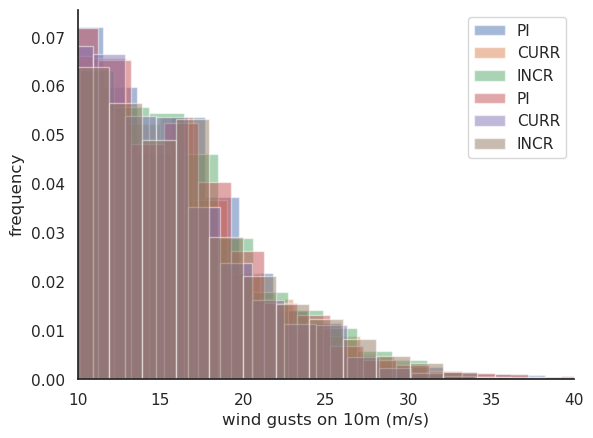

In [ ]:
plt.hist(random.sample(wind_gusts_pi, 10000), alpha = 0.5, density = True, bins = 20, label = 'PI')
plt.hist(random.sample(wind_gusts_curr, 10000), alpha = 0.5, density = True, bins = 20, label = 'CURR')
plt.hist(random.sample(wind_gusts_incr, 10000), alpha = 0.5, density = True, bins = 20, label = 'INCR')
plt.xlabel('wind gusts on 10m (m/s)')
plt.ylabel('frequency')
plt.legend()
sns.despine()

plt.hist(random.sample(wind_gusts_pi, 10000), alpha = 0.5, density = True, bins = 20, label = 'PI')
plt.hist(random.sample(wind_gusts_curr, 10000), alpha = 0.5, density = True, bins = 20, label = 'CURR')
plt.hist(random.sample(wind_gusts_incr, 10000), alpha = 0.5, density = True, bins = 20, label = 'INCR')
plt.xlabel('wind gusts on 10m (m/s)')
plt.ylabel('frequency')
plt.legend()
sns.despine()
plt.xlim((10,40,))

#plt.savefig('figures/01_wind_gusts_hist_zoom.pdf')
#plt.savefig('figures/01_wind_gusts_hist_zoom.png')



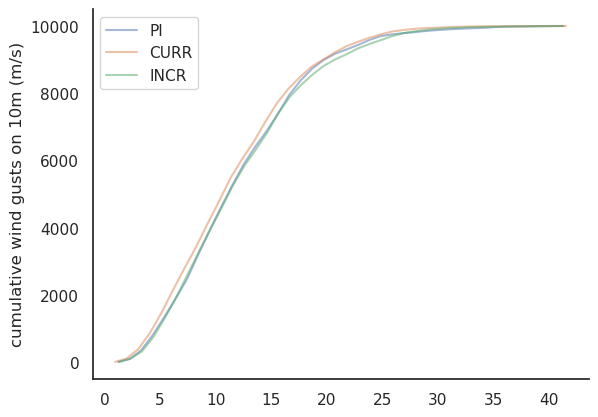

In [ ]:
values_pi, base_pi = np.histogram(random.sample(wind_gusts_pi, 10000), bins = 40)
values_curr, base_curr = np.histogram(random.sample(wind_gusts_curr, 10000), bins = 40)
values_incr, base_incr = np.histogram(random.sample(wind_gusts_incr, 10000), bins = 40)

cumsum_pi = np.cumsum(values_pi)
cumsum_curr = np.cumsum(values_curr)
cumsum_incr = np.cumsum(values_incr)

plt.plot(base_pi[:-1], cumsum_pi , alpha = 0.5, label = 'PI')
plt.plot(base_curr[:-1], cumsum_curr, alpha = 0.5, label = 'CURR')
plt.plot(base_incr[:-1], cumsum_incr, alpha = 0.5, label = 'INCR')

plt.ylabel('cumulative wind gusts on 10m (m/s)')
plt.legend()
sns.despine()

In [ ]:
print(stats.shapiro(random.sample(wind_gusts_pi, 1000)))  # Normality
print(stats.shapiro(random.sample(wind_gusts_curr, 1000)))
print(stats.levene(random.sample(wind_gusts_pi, 1000), random.sample(wind_gusts_curr, 1000)))  # Homogeneity of variance
print(stats.ttest_ind(random.sample(wind_gusts_pi, 1000)25.5
# Load data from MED-R Preindustrial and increased, as before
directory_exp = '/network/group/aopp/predict/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/'

experiments = ['incr', 'pi']
cfpf = ['cf', 'pf']  # control and perturbed are treated equally
inits = {'pi' : ['b2nq_2022-02-10', 'b2nn_2022-02-14', 'b2ns_2022-02-16'], 
           'incr' : ['b2nr_2022-02-10', 'b2no_2022-02-14', 'b2nt_2022-02-16']}  # members for incr and pi runs

for experiment in experiments:
    for init in inits[experiment]:
        for cont in cfpf:
            if experiment == 'pi':
                wind_gusts_pi.append(xr.open_dataset(os.path.join(directory_exp,experiment,'EU025/sfc',cont,init+'.nc')).fg10.values)        
            elif experiment == 'incr':
                wind_gusts_incr.append(xr.open_dataset(os.path.join(directory_exp,experiment,'EU025/sfc',cont,init+' random.sample(wind_gusts_incr, 1000)))  # Homogeneity of variance
print(stats.ttest_ind(random.sample(wind_gusts_curr, 1000), random.sample(wind_gusts_incr, 1000)))



ShapiroResult(statistic=0.970289945602417, pvalue=1.975142732745308e-13)
ShapiroResult(statistic=0.9628646373748779, pvalue=2.8661913574685224e-15)
LeveneResult(statistic=0.2633594466941978, pvalue=0.6078782437130601)
Ttest_indResult(statistic=2.6394876732692785, pvalue=0.008367705837780194)
ShapiroResult(statistic=0.9659934043884277, pvalue=1.5782110996754098e-14)
ShapiroResult(statistic=0.9612100124359131, pvalue=1.2101498307533513e-15)
LeveneResult(statistic=0.0012661036516824406, pvalue=0.9716189362446234)
Ttest_indResult(statistic=-2.4652364259519204, pvalue=0.01377581186477259)


In [ ]:
# Fit weibull distribution
fit_pi= sc.stats.weibull_min.fit(random.sample(wind_gusts_pi, 10000))
fit_curr= sc.stats.weibull_min.fit(random.sample(wind_gusts_curr, 10000))
fit_incr= sc.stats.weibull_min.fit(random.sample(wind_gusts_incr, 10000))
print(fit_pi)
print(fit_curr)
print(fit_incr)

(1.9673134738137055, 1.4691077714749077, 12.903935765789601)
(1.921738074912684, 1.5756022987022766, 12.110148524331631)
(1.9973282838845985, 1.2940699372343258, 13.449150142941308)


In [ ]:
wind_gusts_pi = []
wind_gusts_incr = []

# Load data from MED-R Preindustrial and increased, as before
directory_exp = '/network/group/aopp/predict/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/'
experiments = ['incr', 'pi']
cfpf = ['cf', 'pf']  # control and perturbed are treated equally
inits = {'pi' : ['b2ns_2022-02-16'], 
           'incr' : ['b2nt_2022-02-16']}  # members for incr and pi runs

for experiment in experiments:
    for init in inits[experiment]:
        for cont in cfpf:
            if experiment == 'pi':
                wind_gusts_pi.append(xr.open_dataset(os.path.join(directory_exp,experiment,'EU025/sfc',cont,init+'.nc')).fg10.values)        
            elif experiment == 'incr':
                wind_gusts_incr.append(xr.open_dataset(os.path.join(directory_exp,experiment,'EU025/sfc',cont,init+'.nc')).fg10.values)



In [ ]:
# Import lat, lon values
lat = xr.open_dataset(os.path.join(directory_exp,experiment,'EU025/sfc',cont,init+'.nc')).latitude.values
lon = xr.open_dataset(os.path.join(directory_exp,experiment,'EU025/sfc',cont,init+'.nc')).longitude.values
 
# Import time steps, NB there are three sets of time steps depending on the initialisation date
fridays = []
for init in inits['pi']:  # time stamps are the same across experiments pi and icnr
    time = xr.open_dataset(os.path.join(directory_exp,experiment,'EU025/sfc',cont,init+'.nc')).time.values
    fridays.append((time > pd.Timestamp(2022,2,18, 0)) & (time < pd.Timestamp(2022,2,18, 18)))

# Defining box to analyse winds, south england and wales
lat1 = 52.2
lat2 = 50.3
lon1 = -6
lon2 = 1.3

# Create mask
south_england = {'lat': (lat < lat1) & (lat > lat2), 'lon': (lon < lon2) & (lon > lon1)}
friday = (time > pd.Timestamp(2022,2,18, 0)) & (time < pd.Timestamp(2022,2,18, 18))

1. experiment as a variable has only one value--'pi', but what if we want to use both values in the experiments (tuple?)--another for loop? eh
2. os.path.join(), interesting function that i hardly ever used--but apparently I need to get familar with the website itself first
3. What is a MASK? just a time/spatial bc?

In [ ]:
wind_gusts_incr_south = []
wind_gusts_pi_south = []
init_step = 0  # used to loop through fridays i.e. time step mask which varies depending on init date
for i in range(len(wind_gusts_incr)): # going through the combinations of cf/pf and inits
    if i in [0,2,4]:
        masks = np.meshgrid(fridays[init_step], south_england['lat'], south_england['lon'], indexing = 'ij')
        full_mask = np.ma.make_mask(masks[0]*masks[1]*masks[2])
        wind_gusts_incr_south.append(wind_gusts_incr[i][full_mask].reshape(5,7,29)) 
        wind_gusts_pi_south.append(wind_gusts_pi[i][full_mask].reshape(5,7,29))
    elif i in  [1,3,5]:
        masks = np.meshgrid(fridays[init_step], np.ones(50), south_england['lat'], south_england['lon'], indexing = 'ij')
        full_mask = np.ma.make_mask(masks[0]*masks[1]*masks[2]*masks[3])
        pi = wind_gusts_pi[i][full_mask].reshape(5,50,7,29)
        incr = wind_gusts_incr[i][full_mask].reshape(5,50,7,29)
        for member in range(50): # add members individually but they are equal to the control runs
            wind_gusts_pi_south.append(pi[:,member,:,:])
            wind_gusts_incr_south.append(incr[:,member,:,:])
        init_step += 1

wind_gusts_incr_south = np.stack(wind_gusts_incr_south)
wind_gusts_pi_south = np.stack(wind_gusts_pi_south)

In [ ]:
plt.hist(wind_gusts_pi_south.flatten(), alpha = 0.5, density = True, bins = 20, label = 'PI')
plt.hist(wind_gusts_incr_south.flatten(),  alpha = 0.5, density = True, bins = 20, label = 'INCR')
plt.xlabel('wind gusts on 10m (m/s)')
plt.ylabel('frequency')
plt.legend()
plt.title('Wind gusts (fg10) for southern UK, Friday 18/02/2022')
sns.despine()

plt.savefig('figures/01_wind_gusts_hist.pdf')
plt.savefig('figures/01_wind_gusts_hist.png')


NameError: name 'plt' is not defined

there is an error message at the last bit, which states that the file path can't be found and thus the figure can't be saved. This doesn't matter apparently. I don't have the correct directory